In [2]:
# imports 
import pandas as pd
import nltk
import tensorflow as tf
import numpy as np 

# my files imports 
from utility.get_data import download_and_load_sts_data


In [3]:

sts_dev, sts_test = download_and_load_sts_data()
sts_test.head()

,sent_1,sent_2,sim
0,A girl is styling her hair.,A girl is brushing her hair.,2.5
1,A group of men play soccer on the beach.,A group of boys are playing soccer on the beach.,3.6
2,One woman is measuring another woman's ankle.,A woman measures another woman's ankle.,5.0
3,A man is cutting up a cucumber.,A man is slicing a cucumber.,4.2
4,A man is playing a harp.,A man is playing a keyboard.,1.5


In [5]:
# I organize my data noww

from sklearn.model_selection import KFold
X = sts_dev[['sent_1','sent_1']]
X1 = sts_dev['sent_1']
X2 = sts_dev['sent_2']
y = sts_dev['sim']


X1test = sts_test['sent_1']
X2test = sts_test['sent_2']
ytest = sts_test['sim']

kf = KFold(n_splits=10, shuffle=True)
for train_index, val_index in kf.split(X):
    X1_train, X1_val = X1.iloc[train_index], X1.iloc[val_index]
    X2_train, X2_val = X2.iloc[train_index], X2.iloc[val_index]

    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

In [6]:
import re
from nltk.corpus import stopwords

import string

def remove_punctuation(text):
    new_text = ''.join(c for c in text if c not in string.punctuation)
    return new_text
def clean_text(text):
    ''' Pre process and convert texts to a list of words '''
    text = str(text)
    text = text.lower()
    
    remove_digits = str.maketrans('', '', '0123456789')
    text = text.translate(remove_digits)
    
    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)
    return text
def remove_stopwords(text):
    # Tokenize the text into words
    words = nltk.word_tokenize(text)
    # Get the list of English stop words
    stop_words = set(stopwords.words('english'))
    # Remove the stop words from the list of words
    filtered_words = [word for word in words if word.lower() not in stop_words]
    # Join the filtered words back into a single string
    return ' '.join(filtered_words)

In [5]:
X1_train = X1_train.apply(lambda x: remove_stopwords(remove_punctuation(clean_text(x))))
X2_train = X2_train.apply(lambda x: remove_stopwords(remove_punctuation(clean_text(x))))
X1test= X1test.apply(lambda x: remove_stopwords(remove_punctuation(clean_text(x))))
X2test = X2test.apply(lambda x: remove_stopwords(remove_punctuation(clean_text(x))))

In [6]:
# Ww load the model onceeee
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('distilbert-base-nli-mean-tokens')
def get_sentence_embeddings(data, model = model):
    embeddings = model.encode(data)
    return embeddings

In [7]:
X1_train.reset_index(drop=True, inplace=True)
X2_train.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)
X1_val.reset_index(drop=True, inplace=True)
X2_val.reset_index(drop=True, inplace=True)
y_val.reset_index(drop=True, inplace=True)
X1test.reset_index(drop=True, inplace=True)
X2test.reset_index(drop=True, inplace=True)
ytest.reset_index(drop=True, inplace=True)

In [8]:
embedding1 = get_sentence_embeddings(X1_train)
embedding2 = get_sentence_embeddings(X2_train)


In [9]:
embedding1val = get_sentence_embeddings(X1_val)
embedding2val = get_sentence_embeddings(X2_val)


In [10]:
embedding1test = get_sentence_embeddings(X1test)
embedding2test = get_sentence_embeddings(X2test)

In [11]:
embedding1.shape

(1350, 768)

In [12]:
# We need to reshape our embeddings to 3D to put them in lstm shape will be (None = Batch size, timesteps = nb units = max-seq-len, input-dim = embedding_size)
embedding1 = embedding1.reshape((embedding1.shape[0], 1, -1)) 
embedding2 = embedding2.reshape((embedding2.shape[0], 1, -1)) 
embedding1val = embedding1val.reshape((embedding1val.shape[0], 1, -1)) 
embedding2val = embedding2val.reshape((embedding2val.shape[0], 1, -1)) 
embedding1test = embedding1test.reshape((embedding1test.shape[0], 1, -1)) 
embedding2test = embedding2test.reshape((embedding2test.shape[0], 1, -1)) 

In [13]:
embedding1.shape

(1350, 1, 768)

In [1]:
#defining some params en pus des optimizers
hidden_units= 128
num_epochs= 500
batch_size = 32
embedding_dim = 768 
learning_rate = 3e-3

# Now i prepare optimizers with a clip to avoid exploading gradients 
from tensorflow.keras.optimizers import Adadelta, SGD, RMSprop, Adagrad, Adam, Adamax, Nadam

gradient_clipping_norm = 1.25

adadelta = Adadelta(clipnorm=gradient_clipping_norm, learning_rate=learning_rate)
sgd = SGD(clipnorm=gradient_clipping_norm, learning_rate=learning_rate)
rmsprop = RMSprop(clipnorm=gradient_clipping_norm, learning_rate = learning_rate)
adagrad = Adagrad(clipnorm=gradient_clipping_norm, learning_rate=learning_rate)
adam = Adam(clipnorm=gradient_clipping_norm, learning_rate=learning_rate)
adamax = Adamax(clipnorm=gradient_clipping_norm, learning_rate=learning_rate)
nadam = Nadam(clipnorm=gradient_clipping_norm, learning_rate=learning_rate)

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, GRU, Flatten,GlobalAveragePooling1D, Dense, Bidirectional, Dropout, BatchNormalization, GlobalMaxPooling1D
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras import backend as K


def contrastive_loss(y_true, y_pred, margin=1):
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)
    
class Base(tf.keras.Model):
    
    def __init__(
        self,
        embedding_size,
        hidden_units,
        optimizer,
        dropout_rate=0.3,
        l1_reg=0.0,
        l2_reg=0.0,
    ):
        super(Base, self).__init__()

        self.embedding_size = embedding_size
        self.hidden_units = hidden_units
        self.dropout_rate = dropout_rate
        self.reg = l1_l2(l1=l1_reg, l2=l2_reg)

        self.input_x1 = Input(shape=(None, self.embedding_size), name="input_x1")
        self.input_x2 = Input(shape=(None, self.embedding_size), name="input_x2")

        # create two LSTM layers, one for each input
        self.lstm_1 = Bidirectional(LSTM(self.hidden_units, activation = 'relu',kernel_regularizer=self.reg))(self.input_x1)
        self.lstm_2 = Bidirectional(LSTM(self.hidden_units, activation = 'relu',kernel_regularizer=self.reg))(self.input_x2)

        # add dropout layer
        self.dropout_1 = Dropout(self.dropout_rate)(self.lstm_1)
        self.dropout_2 = Dropout(self.dropout_rate)(self.lstm_2)


        # cal the distance
        self.x1_norm = tf.math.l2_normalize(self.dropout_1, axis=1)
        self.x2_norm = tf.math.l2_normalize(self.dropout_2, axis=1)
        self.cosine_distance = tf.math.reduce_sum(tf.math.multiply(self.x1_norm, self.x2_norm), axis=1)
        self.cosine_distance = tf.reshape(self.cosine_distance, (-1, 1))

        # add a Dense layer
        self.outt = Dense(1, activation='sigmoid')(self.cosine_distance)

        # multiply the output by 5 to get similarity score from 0 to 5
        self.similarity = tf.math.multiply(self.outt, 5)

        # Definition of the model and compile it
        self.model = tf.keras.models.Model(inputs=[self.input_x1, self.input_x2], outputs=[self.similarity])
        self.optimizer = optimizer
        self.model.compile(loss='mse', optimizer=optimizer)


In [3]:
baseModel = Base(embedding_size = embedding_dim, hidden_units = hidden_units, optimizer=rmsprop)

In [27]:
type(embedding1val[0][0][0])

numpy.float32

In [28]:
from keras.callbacks import CSVLogger, TensorBoard, ReduceLROnPlateau, ModelCheckpoint, EarlyStopping, TerminateOnNaN

# train model
callbacks = [
    ModelCheckpoint(filepath='models n logs/best_model_lstm.h5', monitor='val_loss', save_best_only=True),
    EarlyStopping(monitor='val_loss', patience=10),
    CSVLogger('models n logs/training_lstm.log'),
    TensorBoard(log_dir='./logs_lstm'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5),  
    TerminateOnNaN(),
]


with tf.device('/gpu:0'):

    history = baseModel.model.fit(
            x=[embedding1, embedding2],
            y=y_train.to_numpy(),
            epochs=num_epochs,
            batch_size=batch_size,
            validation_data=([embedding1val, embedding2val], y_val.to_numpy()),
            callbacks=callbacks,
            shuffle=True
        )

Epoch 1/500
43/43 [==============================] - 5s 37ms/step - loss: 2.1921 - val_loss: 1.8977
Epoch 2/500
43/43 [==============================] - 1s 13ms/step - loss: 1.9483 - val_loss: 1.7393
Epoch 3/500
43/43 [==============================] - 1s 14ms/step - loss: 1.8026 - val_loss: 1.8364
Epoch 4/500
43/43 [==============================] - 1s 14ms/step - loss: 1.6991 - val_loss: 1.6780
Epoch 5/500
43/43 [==============================] - 1s 14ms/step - loss: 1.6006 - val_loss: 1.6787
Epoch 6/500
43/43 [==============================] - 1s 14ms/step - loss: 1.4826 - val_loss: 1.8146
Epoch 7/500
43/43 [==============================] - 1s 14ms/step - loss: 1.3971 - val_loss: 1.7071
Epoch 8/500
43/43 [==============================] - 1s 14ms/step - loss: 1.3052 - val_loss: 1.6739
Epoch 9/500
43/43 [==============================] - 1s 14ms/step - loss: 1.2399 - val_loss: 1.7178
Epoch 10/500
43/43 [==============================] - 1s 13ms/step - loss: 1.1305 - val_loss: 1.7213

In [29]:
# make a prediction using your trained Siamese LSTM model
predictions = baseModel.model.predict([embedding1test, embedding2test])
print(f"Prediction: {predictions}")

Prediction: [[2.712517 ]
 [1.2227178]
 [2.2371798]
 ...
 [1.7833099]
 [2.7466278]
 [1.1902333]]


In [30]:
baseModel.model.save("LSTMMODEL.h5")

In [31]:
# we change dimension to evaluate our model when return sequences is true

predictions_2d = predictions.mean(axis=1)
predictions_1d = predictions_2d.flatten()


In [32]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score

predictions = predictions_1d

# Compute the mean squared error (MSE)
mse = mean_squared_error(ytest, predictions)
print(f"Mean squared error: {mse:.2f}")

# Compute the mean absolute error (MAE)
mae = mean_absolute_error(ytest, predictions)
print(f"Mean absolute error: {mae:.2f}")

# Compute the R-squared (R2) score
r2 = r2_score(ytest, predictions)
print(f"R-squared score: {r2:.2f}")

# Compute the explained variance score
evs = explained_variance_score(ytest, predictions)
print(f"Explained variance score: {evs:.2f}")

Mean squared error: 2.21
Mean absolute error: 1.22
R-squared score: 0.05
Explained variance score: 0.10


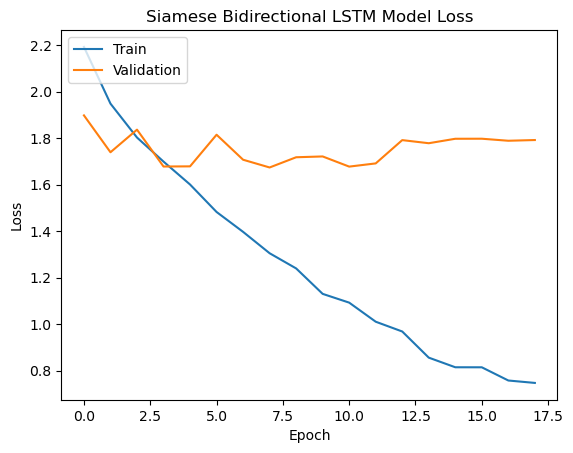

In [33]:
import matplotlib.pyplot as plt


# Plot the training loss and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Siamese Bidirectional LSTM Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('plots/loss_plot_lstm.png')
plt.show()
